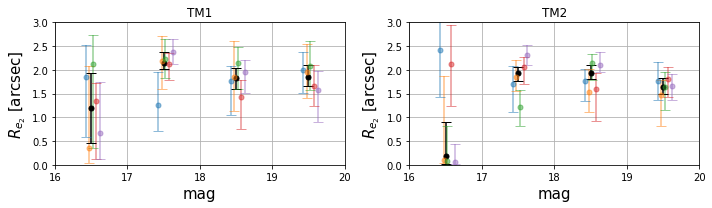

In [187]:
from run_fit import *


fig, ax = plt.subplots(1, 2, figsize = (10,3))
for i,inst in enumerate([1,2]):
    for ifield in [None,4,5,6,7,8]:
        xoff = 0 if ifield is None else (ifield-5.5)*0.05
        Re2_arr = np.zeros(4)
        Re2_low_arr = np.zeros(4)
        Re2_high_arr = np.zeros(4)
        Re2_W19_arr = np.zeros(4)
        for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
            subsub = True if im==0 else False
            R200 = gal_profile_model().Wang19_profile(0,im)['params']['R200']
            xe2_W19 = gal_profile_model().Wang19_profile(0,3)['params']['sersic2'][2]
            Re2_W19 = R200 * xe2_W19
            Re2_W19_arr[im] = Re2_W19

            fitparamdat = get_mcmc_fit_params_3par(inst,im, ifield=ifield, subsub=subsub)

            Re2_arr[im] = fitparamdat['Re2']
            Re2_low_arr[im] = fitparamdat['Re2_low']
            Re2_high_arr[im] = fitparamdat['Re2_high']

        m_arr = (np.array(magbindict['m_min']) + np.array(magbindict['m_max'])) / 2

        if ifield is None:
            ax[i].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                          fmt='.', capsize=5, markersize=10, c='k', label = 'joint fit')
        else:
            ax[i].errorbar(m_arr+xoff, Re2_arr, [Re2_arr - Re2_low_arr, Re2_high_arr - Re2_arr],
                          fmt='.', capsize=5, markersize=10, alpha = 0.5, label = fieldnamedict[ifield])

    # ax[0].axhline(xe2_W19, c='grey')
    ax[i].set_ylim([0,3])
    ax[i].set_xlabel('mag', fontsize=15)
    ax[i].set_ylabel(r"$R_{e_2}$ [arcsec]", fontsize=15)
    ax[i].set_xticks([16,17,18,19,20])
    ax[i].grid()
    ax[i].set_title('TM%d'%inst)

    plt.tight_layout()
    plt.savefig('/Users/ytcheng/Desktop/params_best_3par.png', dpi = 150)

In [64]:
# from stack_ancillary import *
# # from reduction import *
# # data_maps = {1: image_reduction(1), 2: image_reduction(2)}

# srcdict = {}
# m_data = (np.array(magbindict['m_min']) + np.array(magbindict['m_max'])) / 2
# Re2_data1 = np.zeros_like(m_data)
# Re2_data2 = np.zeros_like(m_data)
# for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
#     subsub = True if im==0 else False
#     fitparamdat = get_mcmc_fit_params_3par(1,im, ifield=None, subsub=subsub)
#     Re2_data1[im] = fitparamdat['Re2']
#     fitparamdat = get_mcmc_fit_params_3par(2,im, ifield=None, subsub=subsub)
#     Re2_data2[im] = fitparamdat['Re2']
# Re2_interp_func1 = scipy.interpolate.interp1d(m_data, Re2_data1, fill_value='extrapolate')
# Re2_interp_func2 = scipy.interpolate.interp1d(m_data, Re2_data2, fill_value='extrapolate')
# srcdict = {'m_data':m_data, 'Re2_data1':Re2_data1, 'Re2_data2':Re2_data2,
#           'Re2_interp_func1':Re2_interp_func1, 'Re2_interp_func2':Re2_interp_func2}
    
# for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
#     srcdict[im] = {'z':np.array([]), 'm':np.array([])}
#     for i,ifield in enumerate([4,5,6,7,8]):
#         mask_inst1, mask_inst2 = load_processed_images(data_maps,
#                               return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
#         field = fieldnamedict[ifield]
#         srcdat = ps_src_select(1, ifield, m_min, m_max, 
#             [mask_inst1, mask_inst2], sample_type='all')
#         srcdict[im]['z'] = np.concatenate((srcdict[im]['z'],np.array(srcdat['zg_arr'])))
#         srcdict[im]['m'] = np.concatenate((srcdict[im]['m'],np.array(srcdat['mg_arr'])))
        
#     DA_Mpc = cosmo.angular_diameter_distance(srcdict[im]['z']).value
#     srcdict[im]['Re2_arcsec1'] = srcdict['Re2_interp_func1'](srcdict[im]['m'])
#     srcdict[im]['Re2_kpc1'] = srcdict[im]['Re2_arcsec1'] * DA_Mpc * (u.Mpc/u.rad).to(u.kpc/u.arcsec)
#     srcdict[im]['Re2_arcsec2'] = srcdict['Re2_interp_func2'](srcdict[im]['m'])
#     srcdict[im]['Re2_kpc2'] = srcdict[im]['Re2_arcsec2'] * DA_Mpc * (u.Mpc/u.rad).to(u.kpc/u.arcsec)

#     zs = srcdict[im]['z']
#     ms = srcdict[im]['m']
#     DM = 5 * np.log10((cosmo.luminosity_distance(zs) / (10 * u.pc)).decompose()).value
#     Ms = ms - DM + (2.5 * np.log10(1+zs))
#     srcdict[im]['M'] = ms - DM + (2.5 * np.log10(1+zs))

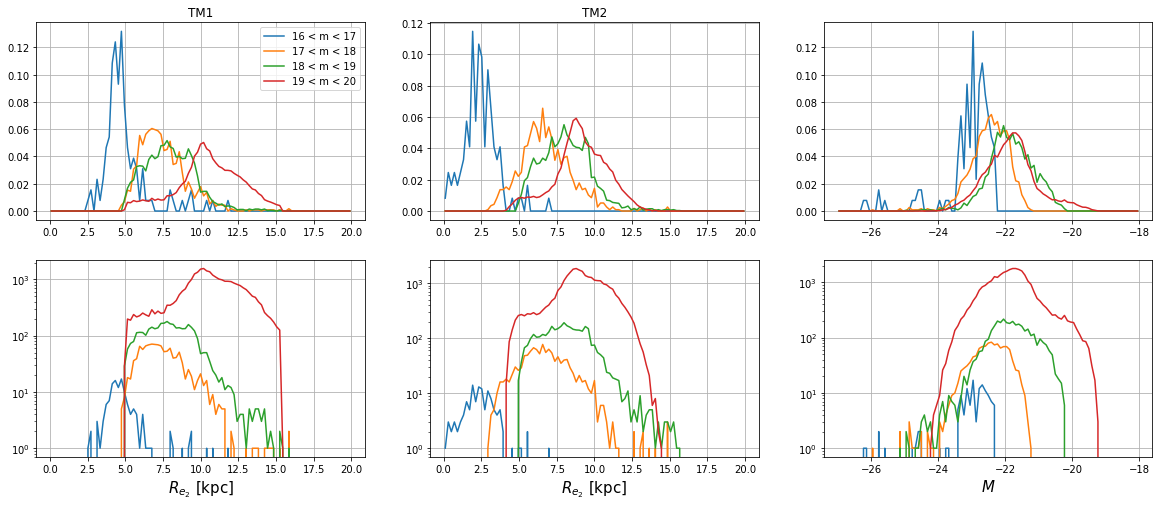

In [215]:
fig, ax = plt.subplots(2,3, figsize=(20,8))
Rbinedges = np.linspace(0,20,100)
Rbins = (Rbinedges[1:] + Rbinedges[:-1])/2
Mbinedges = np.linspace(-27,-18,100)
Mbins = (Mbinedges[1:] + Mbinedges[:-1])/2
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    hist = np.histogram(srcdict[im]['Re2_kpc1'], bins=Rbinedges)[0]
    ax[0][0].plot(Rbins, hist/np.sum(hist),label='%d < m < %d'%(m_min, m_max))
    ax[1][0].semilogy(Rbins, hist,label='%d < m < %d'%(m_min, m_max))
    hist = np.histogram(srcdict[im]['Re2_kpc2'], bins=Rbinedges)[0]
    ax[0][1].plot(Rbins, hist/np.sum(hist),label='%d < m < %d'%(m_min, m_max))
    ax[1][1].semilogy(Rbins, hist,label='%d < m < %d'%(m_min, m_max))
    hist = np.histogram(srcdict[im]['M'], bins=Mbinedges)[0]
    ax[0][2].plot(Mbins, hist/np.sum(hist))    
    ax[1][2].semilogy(Mbins, hist)    

ax[0][0].legend()
ax[0][0].set_title('TM1')
ax[0][0].grid()
ax[0][1].set_title('TM2')
ax[0][1].grid()
ax[0][2].grid()

ax[1][0].set_xlabel(r"$R_{e_2}$ [kpc]",fontsize=15)
ax[1][0].grid()
ax[1][1].set_xlabel(r"$R_{e_2}$ [kpc]",fontsize=15)
ax[1][1].grid()
ax[1][2].set_xlabel(r"$M$",fontsize=15)
ax[1][2].grid()
plt.savefig('/Users/ytcheng/Desktop/Re2_M_hist.png', dpi = 150)

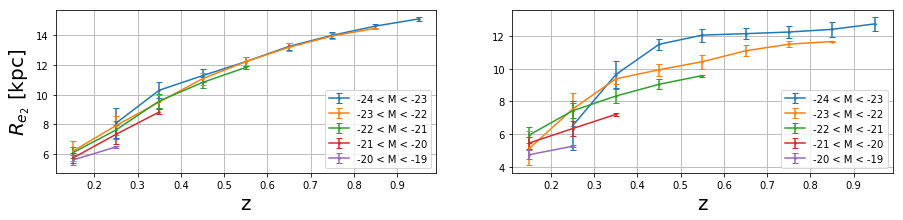

In [288]:
fig, ax = plt.subplots(1,2, figsize=(15,3))

zs = np.concatenate((srcdict[1]['z'],srcdict[2]['z'],srcdict[3]['z']))
Re2s1 = np.concatenate((srcdict[1]['Re2_kpc1'],srcdict[2]['Re2_kpc1'],srcdict[3]['Re2_kpc1']))
Re2s2 = np.concatenate((srcdict[1]['Re2_kpc2'],srcdict[2]['Re2_kpc2'],srcdict[3]['Re2_kpc2']))
ms = np.concatenate((srcdict[1]['m'],srcdict[2]['m'],srcdict[3]['m']))
Ms = np.concatenate((srcdict[1]['M'],srcdict[2]['M'],srcdict[3]['M']))

Msbinedges = np.arange(-24,-18,1)
Msbins = (Msbinedges[1:] + Msbinedges[:-1])/2
zbinedges = np.arange(0,1.1,0.1)
zbins = (zbinedges[1:] + zbinedges[:-1])/2
for i,(Ms_min, Ms_max) in enumerate(zip(Msbinedges[:-1], Msbinedges[1:])):
    sp = np.where((Ms>=Ms_min) & (Ms<Ms_max))[0]
    if len(sp)==0:
        continue
    zi, Re21i, Re22i = zs[sp], Re2s1[sp], Re2s2[sp]
    Re21_arr = []
    Re22_arr = []
    Re21_err = []
    Re22_err = []
    z_arr = []
    for iz,(z_min,z_max) in enumerate(zip(zbinedges[:-1], zbinedges[1:])):
        spz = np.where((zi>=z_min) & (zi<z_max))[0]
        if len(spz)==0:
            continue
        z_arr.append(zbins[iz])
        Re21_arr.append(np.mean(Re21i[spz]))
        Re22_arr.append(np.mean(Re22i[spz]))
        Re21_err.append(np.std(Re21i[spz]))
        Re22_err.append(np.std(Re22i[spz]))
    ax[0].errorbar(z_arr, Re21_arr,Re21_err, fmt ='.-', 
                   capsize=3,markersize=3, label='%d < M < %d'%(Ms_min, Ms_max))
    ax[1].errorbar(z_arr, Re22_arr,Re22_err, fmt ='.-', 
                   capsize=3,markersize=3, label='%d < M < %d'%(Ms_min, Ms_max))
ax[0].legend()
ax[1].legend()
ax[0].grid()
ax[1].grid()
ax[0].set_xlabel('z',fontsize=20)
ax[1].set_xlabel('z',fontsize=20)
ax[0].set_ylabel(r"$R_{e_2}$ [kpc]",fontsize=20)
plt.savefig('/Users/ytcheng/Desktop/Re2_z.png', dpi = 150)

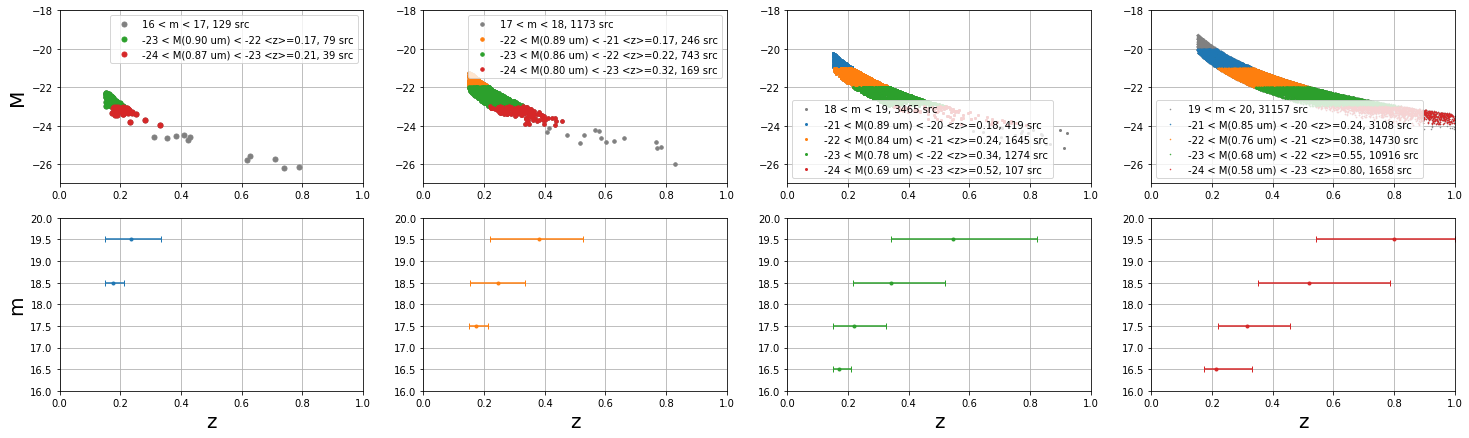

In [609]:
Msbinedges = np.arange(-20,-25,-1)
fig, ax = plt.subplots(2,4, figsize=(25,7))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    zs = srcdict[im]['z']
    kpc_per_arcsecs = 1/cosmo.arcsec_per_kpc_proper(zs).value
    Re2s1s = srcdict[im]['Re2_kpc1']
    Re2s2s = srcdict[im]['Re2_kpc2']
    ms = srcdict[im]['m']
    Ms = srcdict[im]['M']
    
    ax[0][im].plot(zs, Ms,'.',markersize=10 - 3*im, c='grey',
                   label='%d < m < %d, %d src'%(m_min,m_max,len(zs)))
    for i,(Ms_min,Ms_max) in enumerate(zip(Msbinedges[1:],Msbinedges[:-1])):
        sp = np.where((Ms>=Ms_min) & (Ms<Ms_max))[0]
        if len(sp)==0:
            continue
        
        zavg = np.mean(zs[sp])
        kpc_per_arcsecavg = np.mean(kpc_per_arcsecs[sp])
        N = len(sp)
        wl_rest = band_info(1).wl / (1+zavg)        
        ax[0][im].plot(zs[sp], Ms[sp], '.',markersize=10 - 3*im, c='C'+str(i),
                       label='%d < M(%.2f um) < %d <z>=%.2f, %d src'%(Ms_min,wl_rest, Ms_max,zavg,N))
        ax[1][i].errorbar([zavg],(m_min+m_max)/2,
                           xerr=np.array([[zavg-np.min(zs[sp]),np.max(zs[sp]-zavg)]]).T,
                          c='C'+str(i), fmt='.',capsize=3)

        ax[1][i].set_xlim([0,1])
        ax[1][i].set_ylim([16,20]) 

    ax[0][im].set_xlim([0,1])
    ax[0][im].set_ylim([-27,-18])
    ax[0][im].grid()
    ax[0][im].legend()
for i in range(4):
    ax[1][i].grid() 
    ax[1][i].set_xlabel('z',fontsize=20)
ax[0][0].set_ylabel('M',fontsize=20)
ax[1][0].set_ylabel('m',fontsize=20)
plt.savefig('/Users/ytcheng/Desktop/Mbins.png', dpi = 150)

Text(0, 0.5, 'kpc/arcsec')

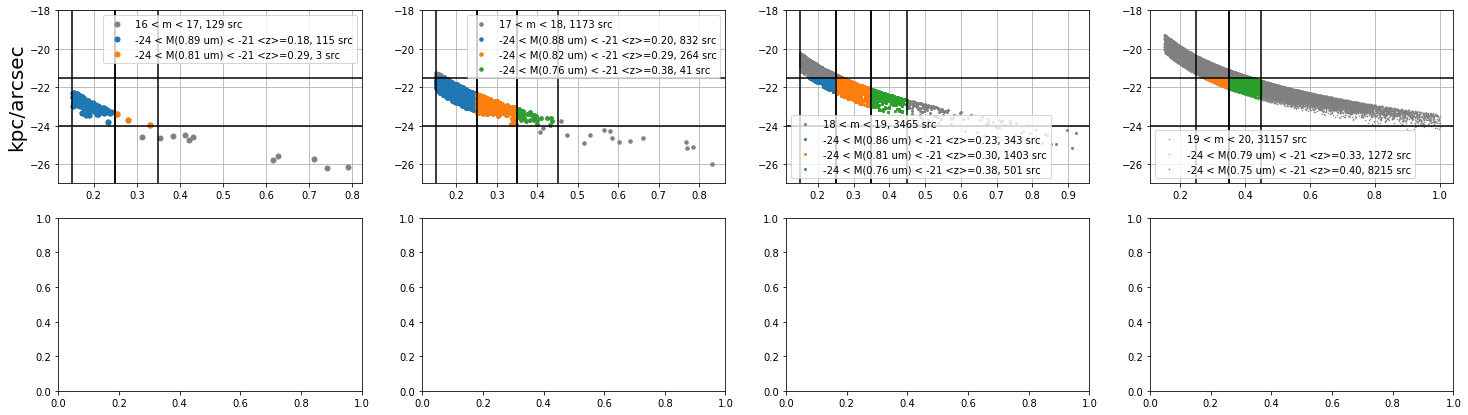

In [649]:
Ms_min, Ms_max = -24, -21.5
zbinedges = np.arange(0.15,0.55,0.1)
fig, ax = plt.subplots(2,4, figsize=(25,7))
for im,(m_min,m_max) in enumerate(zip(magbindict['m_min'],magbindict['m_max'])):
    zs = srcdict[im]['z']
    kpc_per_arcsecs = 1/cosmo.arcsec_per_kpc_proper(zs).value
    Re2s1s = srcdict[im]['Re2_kpc1']
    Re2s2s = srcdict[im]['Re2_kpc2']
    ms = srcdict[im]['m']
    Ms = srcdict[im]['M']
    
    ax[0][im].plot(zs, Ms,'.',markersize=10 - 3*im, c='grey',
                   label='%d < m < %d, %d src'%(m_min,m_max,len(zs)))
                   
    for i,(z_min,z_max) in enumerate(zip(zbinedges[:-1],zbinedges[1:])):
        sp = np.where((zs>=z_min) & (zs<z_max) & (Ms>=Ms_min) & (Ms<Ms_max))[0]
        if len(sp)==0:
            continue  
        zavg = np.mean(zs[sp])
        kpc_per_arcsecavg = np.mean(kpc_per_arcsecs[sp])
        N = len(sp)
        wl_rest = band_info(1).wl / (1+zavg)        
        ax[0][im].plot(zs[sp], Ms[sp], '.',markersize=10 - 3*im, c='C'+str(i),
                       label='%d < M(%.2f um) < %d <z>=%.2f, %d src'%(Ms_min,wl_rest, Ms_max,zavg,N))
#         ax[1][i].errorbar([np.mean(ms[sp])],[np.mean(Ms[sp])],
#                            yerr=np.array([[np.mean(Ms[sp])-np.min(Ms[sp]),
#                                            np.max(Ms[sp]-np.mean(Ms[sp]))]]).T,
#                            xerr=np.array([[np.mean(ms[sp])-np.min(ms[sp]),
#                                            np.max(ms[sp]-np.mean(ms[sp]))]]).T,
#                           c='C'+str(i), fmt='.',capsize=3)
        ax[0][im].axvline(z_min,c='k')
        ax[0][im].axvline(z_max,c='k')
    ax[0][im].axhline(Ms_min,c='k')
    ax[0][im].axhline(Ms_max,c='k')
# #         ax[1][i].set_xlim([0,1])
#         ax[1][i].set_ylim([16,20]) 

#     ax[0][im].set_xlim([0,1])
    ax[0][im].set_ylim([-27,-18])
    ax[0][im].grid()
    ax[0][im].legend()
# for i in range(4):
#     ax[1][i].grid() 
#     ax[1][i].set_xlabel('kpc/arcsec',fontsize=20)
ax[0][0].set_ylabel('kpc/arcsec',fontsize=20)
# ax[1][0].set_ylabel('m',fontsize=20)
# plt.savefig('/Users/ytcheng/Desktop/Mbins.png', dpi = 150)

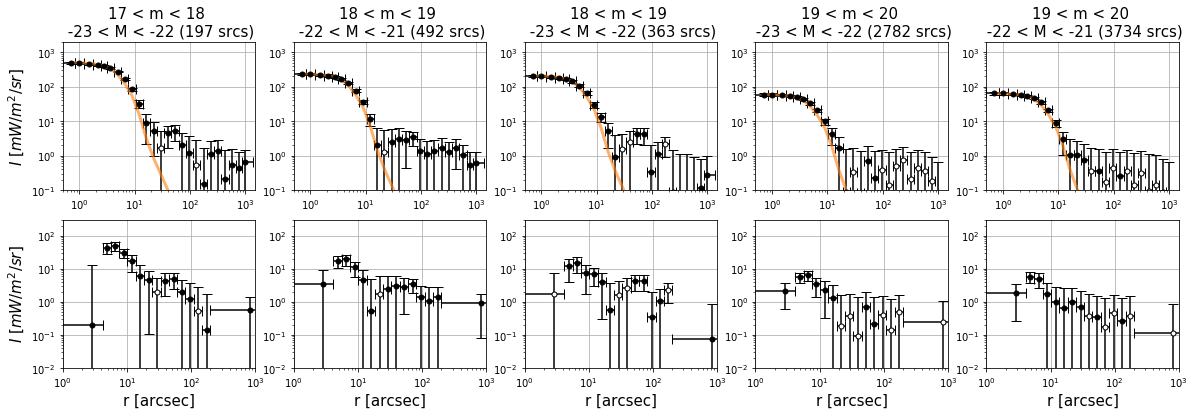

In [17]:
from stack import *

inst = 1
filt_order = filt_order_dict[inst]
m_min_arr = [17,18,18,19,19]
m_max_arr = [18,19,19,20,20]
Mabs_min_arr = [-23,-22,-23,-23,-22]
Mabs_max_arr = [-22,-21,-22,-22,-21]
for ifield in [5]:
    plt.close()
    fig, ax = plt.subplots(2, 5, figsize = (20,6))
    for i,(m_min,m_max,Mabs_min,Mabs_max) in \
    enumerate(zip(m_min_arr,m_max_arr,Mabs_min_arr,Mabs_max_arr)):
        stackdat = stacking(inst, ifield, m_min, m_max, Mabs_min=Mabs_min, Mabs_max=Mabs_max,
                            load_from_file=True, BGsub=False).stackdat

        Nsrc = stackdat['Nsrc']
        r_arr = stackdat['rsubbins']
        profd_arr = stackdat['ex']['profcbsub']
        profd_err = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
        
        rbinedges = stackdat['rsubbinedges']
        
        plot_err_log(r_arr, 
                     profd_arr,
                     profd_err,
                     xedges = rbinedges,
                     ax=ax[1][i], color='k')

        plot_err_log(stackdat['rbins'], 
                     stackdat['profcb'],
                     np.sqrt(np.diag(stackdat['cov']['profcb'])),
                     ax=ax[0][i], color='k',label='Galaxy Stack')

        ax[0][i].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                      'C1', alpha=0.6, lw=3, label='PSF Model')

        ax[0][i].set_title('%d < m < %d \n %d < M < %d (%d srcs)'\
                           %(m_min, m_max, Mabs_min, Mabs_max, Nsrc),fontsize=15)
        ax[0][i].set_ylim([1e-1,2e3])
        ax[0][i].set_xlim([5e-1,1.5e3])
        ax[0][i].grid()
        ax[1][i].set_ylim([1e-2,3e2])
        ax[1][i].set_xlim([1e0,1e3])
        ax[1][i].grid()
        ax[1][i].set_xlabel('r [arcsec]',fontsize=15)
    ax[0][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
    ax[1][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)

#     plt.tight_layout()
#     plt.savefig('plots/TM%d/profile_best_%s_3par.png'%(inst,param_fit.field), dpi = 150)

In [2]:
from run_fit import *
joint_fit_mcmc(1, 1, Mabs_min=-23, Mabs_max=-22).run_mcmc(steps=500,savename='mcmc_3par_joint_m17_18_Mabs-23_-22.npy')
joint_fit_mcmc(1, 2, Mabs_min=-22, Mabs_max=-21).run_mcmc(steps=500,savename='mcmc_3par_joint_m18_19_Mabs-22_-21.npy')
joint_fit_mcmc(1, 2, Mabs_min=-23, Mabs_max=-22).run_mcmc(steps=500,savename='mcmc_3par_joint_m18_19_Mabs-23_-22.npy')
joint_fit_mcmc(1, 3, Mabs_min=-22, Mabs_max=-21).run_mcmc(steps=500,savename='mcmc_3par_joint_m19_20_Mabs-22_-21.npy')
joint_fit_mcmc(1, 3, Mabs_min=-23, Mabs_max=-22).run_mcmc(steps=500,savename='mcmc_3par_joint_m19_20_Mabs-23_-22.npy')

joint_fit_mcmc(1, 1, m_min=16, m_max=20, Mabs_min=-24, Mabs_max=-21.5, z_min=0.15, z_max=0.25).run_mcmc(steps=500,savename='mcmc_3par_joint_m16_20_Mabs-24_-21.5z0.15_0.25.npy')
joint_fit_mcmc(1, 2, m_min=16, m_max=20, Mabs_min=-24, Mabs_max=-21.5, z_min=0.25, z_max=0.35).run_mcmc(steps=500,savename='mcmc_3par_joint_m16_20_Mabs-24_-21.5z0.25_0.35.npy')
joint_fit_mcmc(1, 3, m_min=16, m_max=20, Mabs_min=-24, Mabs_max=-21.5, z_min=0.35, z_max=0.45).run_mcmc(steps=500,savename='mcmc_3par_joint_m16_20_Mabs-24_-21.5z0.35_0.45.npy')

Pre-computing model profiles for interpolation...
Pre-computing model profiles for interpolation...
Pre-computing model profiles for interpolation...
Pre-computing model profiles for interpolation...
Pre-computing model profiles for interpolation...


100%|██████████| 3/3 [00:39<00:00, 13.32s/it]


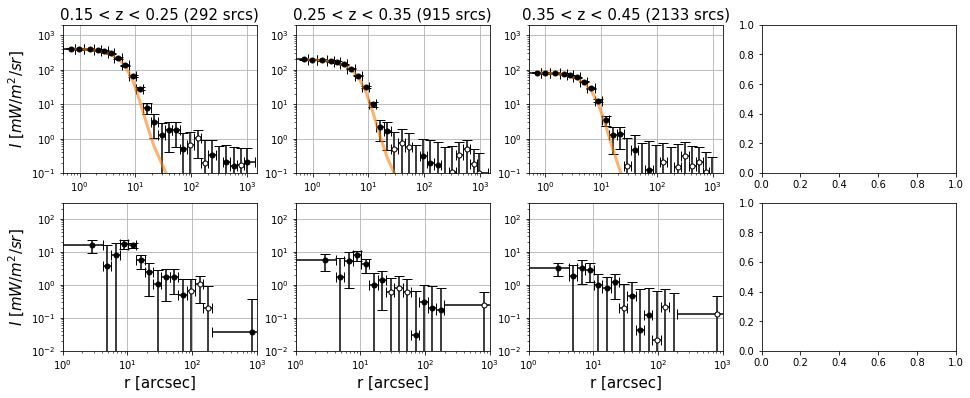

In [1]:
from stack import *

inst = 1
m_min, m_max = 16, 20
Mabs_min, Mabs_max = -24, -21.5
filt_order = filt_order_dict[inst]
for ifield in [8]:
    plt.close()
    fig, ax = plt.subplots(2, 4, figsize = (16,6))
    for i,(z_min,z_max) in enumerate(zip([0.15,0.25,0.35],[0.25,0.35,0.45])):
        stackdat = stacking(inst, ifield, m_min, m_max, Mabs_min=Mabs_min, Mabs_max=Mabs_max,
                            z_min=z_min, z_max=z_max, load_from_file=True, BGsub=False).stackdat

        Nsrc = stackdat['Nsrc']
        r_arr = stackdat['rsubbins']
        profd_arr = stackdat['ex']['profcbsub']
        profd_err = np.sqrt(np.diag(stackdat['excov']['profcbsub']))
        
        rbinedges = stackdat['rsubbinedges']
        
        plot_err_log(r_arr, 
                     profd_arr,
                     profd_err,
                     xedges = rbinedges,
                     ax=ax[1][i], color='k')

        plot_err_log(stackdat['rbins'], 
                     stackdat['profcb'],
                     np.sqrt(np.diag(stackdat['cov']['profcb'])),
                     ax=ax[0][i], color='k',label='Galaxy Stack')

        ax[0][i].loglog(stackdat['rbins'],stackdat['PSF']['profcb'],
                      'C1', alpha=0.6, lw=3, label='PSF Model')

        ax[0][i].set_title('%.2f < z < %.2f (%d srcs)'%(z_min, z_max, Nsrc),fontsize=15)
        ax[0][i].set_ylim([1e-1,2e3])
        ax[0][i].set_xlim([5e-1,1.5e3])
        ax[0][i].grid()
        ax[1][i].set_ylim([1e-2,3e2])
        ax[1][i].set_xlim([1e0,1e3])
        ax[1][i].grid()
        ax[1][i].set_xlabel('r [arcsec]',fontsize=15)
    ax[0][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)
    ax[1][0].set_ylabel(r'$I$ [$mW/m^2/sr$]',fontsize=15)

#     plt.tight_layout()
#     plt.savefig('plots/TM%d/profile_best_%s_3par.png'%(inst,param_fit.field), dpi = 150)

***
# NYU-VAGC

In [579]:
from astropy.table import Table

hdu_list= fits.open('/Users/ytcheng/Downloads/kcorrect.nearest.model.z0.00.fits')
# hdu_list= fits.open('/Users/ytcheng/Downloads/')
df = Table(hdu_list[1].data)

In [582]:
sp = np.where((df['RA']>=241.0) & (df['RA']<244.7) & (df['DEC']>=53.6) & (df['DEC']<55.9))[0]
df = df[sp]

# catalogk = (np.stack([np.array(df['RA']),np.array(df['DEC'])]).T * np.pi/180).tolist()
# psk = [[item[0], item[1]] for item in catalogk]
# catalogp = (df0[['ra','dec']].values * np.pi/180).tolist()
# psp = [[item[0], item[1]] for item in catalogp]
# kdt = cKDTree(psk)
# obj = kdt.query_ball_point(psp, (0.7 * u.arcsec).to(u.rad).value)
# Nmatch = np.array([len(obj_i) for obj_i in obj])
# np.sum(Nmatch)/len(Nmatch)

In [583]:
len(np.where(df['MASS']!=0)[0])

215

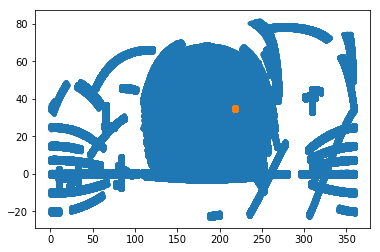

In [559]:
plt.plot(df['RA'],df['DEC'],'.')
plt.plot(df0['ra'],df0['dec'],'.')

In [551]:
i=0
dsq = (ra - df0.iloc[i]['ra'])**2 + (dec - df0.iloc[i]['dec'])**2
df[np.argmin(dsq)]

RA,DEC,ABMAGGIES [8],ABMAGGIES_IVAR [8],Z,ABSMAG [8],ABSMAG_IVAR [8],KCORRECT [8],MTOL [8],MASS,INTSFH,METS,B300,B1000,COEFFS [5]
float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
242.94944465760423,55.306714065837966,6.338634e-09 .. 0.0,8.846317e+17 .. 0.0,-1.0,26505.953 .. 26501.45,30.151243 .. 0.0,0.0 .. 0.0,7.124352 .. 0.22208786,0.0,0.0,0.039702233,1.2442564e-07,0.4030629,1.078997e-05 .. 3.756278e-12


In [556]:
ifield = 7
m_min, m_max = 18,19
mask_inst1, mask_inst2 = load_processed_images(data_maps,
                      return_names=[(1,ifield,'mask_inst'),(2,ifield,'mask_inst')])
field = fieldnamedict[ifield]
srcdat = ps_src_select(1, ifield, m_min, m_max, 
    [mask_inst1, mask_inst2], sample_type='all')

df0 = pd.read_csv(mypaths['PScatdat'] + fieldnamedict[ifield] + '.csv')
df0 = df0.iloc[srcdat['idxg_arr']]